In [80]:
# Make NumPy and scipy modules available for numerical computations
import numpy as np
import scipy as sp
from scipy.optimize import minimize

from functools import lru_cache

import matplotlib.pyplot as plt

### Computing Energy Function and Derivatives

In [81]:
class KL_objective:
    '''
    Class to compute the KL divergence objective function and its gradient for MPF

    Parameters:
        data: N x L numpy array, containing N observations of length L sequences
        q: int, alphabet size
        ep: float, epsilon parameter (see Battaglino 2014)
    '''

    def __init__(self,data,q,ep):
        '''
        Initialize function with current dataset
        '''
        self._data = data # data matrix
        self._q = q # alphabet size
        self._ep = ep # epsilon parameter
        self._N = data.shape[0] # number of sequences in data
        self._L = data.shape[1] # sequence length

    def value(self, params):
        '''
        Compute value of objective at given parameters
        '''
        L = self._L
        N = self._N
        q = self._q
        data = self._data
        ep = self._ep

        sum_prob_diffs = 0; # sum of all probability differences
        for n in range(N): # for all sequences
            sn = data[n,:] # extract nth row
            sum_prob_diffs += compute_adjacent_energy(sn,q,params)

        return ep*sum_prob_diffs/N

    def gradient(self, params):
        '''
        Compute gradient of objective at given parameters
        '''
        L = self._L
        N = self._N
        q = self._q
        data = self._data
        ep = self._ep

        sum_prob_diffs = 0; # sum of all probability differences
        sum_prob_diffs_updated = 0; # sum of all probability differences
        for n in range(N): # for all sequences
            sn = data[n,:] # extract nth row
            sum_prob_diffs += energy_gradient(sn,q,params)
            sum_prob_diffs_updated += gradient_compute_adjacent_energy(sn,q,params)
        return [ep*sum_prob_diffs/N, ep*sum_prob_diffs_updated/N]




In [82]:
def compute_adjacent_energy(s,q,params):
    '''
    Function to compute energy differences of all adjacent sequences to s and then sum the results. i.e.

    sum_{u~s} exp[(1/2)*(Energy(s; params) - Energy(u; params))]

    Inputs:
        s = np.array, represents sequence of integers 1:q (NOT CURRENTLY 0:(q-1))
        q = int, length of sequence
        params = list, contains fields and couplings [fields.shape = (L,q), couplings.shape = (L,L,q,q)]
        NOTE: only part of couplings(i,j,:,:) s.t. i<j is used (i.e. upper tri portion)

    '''
    L = s.shape[0] # length of sequence
    inp_fields = params[0] # field params
    inp_couplings = params[1] # coupling params

    sum_prob_diff_total = 0; # total energy difference summed over adjacent sequences

    for j in range(L): # for each position to differ in
        for qi in range(q): # for each possible flip in this position
            energy_diff_j = inp_fields[j,s[j]] - inp_fields[j,qi] # add the field energy difference
            # NOTE: one of the above terms added will be zero when q = s[j]-1. Not a problem.

            for i in range(j): # for all positions s.t. i < j
                # add difference from couplings
                energy_diff_j += inp_couplings[i,j,s[i],s[j]] - inp_couplings[i,j,s[i],qi]

            for i in range(j+1,L): # for all positions s.t. j < i
                # add difference from couplings
                # NOTE: indices have to be flipped to only use i<j portion of input couplings
                energy_diff_j += inp_couplings[j,i,s[j],s[i]] - inp_couplings[j,i,qi,s[i]]

            sum_prob_diff_total += np.exp(0.5*energy_diff_j) # add probability difference to total sum

    sum_prob_diff_total -= 1 # corrects for case where qi = s[j]-1, which is added above

    return(sum_prob_diff_total)

In [83]:
def compute_adjacent_energy_and_gradient(s,q,params):
    '''
    Function to compute energy differences of all adjacent sequences to s and then sum the results. i.e.

    sum_{u~s} exp[(1/2)*(Energy(s; params) - Energy(u; params))]

    Inputs:
        s = np.array, represents sequence of integers 1:q (NOT CURRENTLY 0:(q-1))
        q = int, alphabet size of sequence
        params = list, contains fields and couplings [fields.shape = (L,q), couplings.shape = (L,L,q,q)]
        NOTE: only part of couplings(i,j,:,:) s.t. i<j is used (i.e. upper tri portion)

    '''
    L = s.shape[0] # length of sequence
    inp_fields = params[0] # field params
    inp_couplings = params[1] # coupling params

    out_fields = np.zeros((L,q))
    out_couplings = np.zeros((L,L,q,q))

    sum_prob_diff_total = 0; # total energy difference summed over adjacent sequences

    for j in range(L): # for each position to differ in
        for qi in range(q): # for each possible flip in this position
            energy_diff_j = inp_fields[j,s[j]] - inp_fields[j,qi] # add the field energy difference
            # NOTE: one of the above terms added will be zero when q = s[j]-1. Not a problem.

            out_fields += np.exp(0.5*(inp_fields[j,s[j]] - inp_fields[j,qi]))

            for i in range(j): # for all positions s.t. i < j
                # add difference from couplings
                energy_diff_j += inp_couplings[i,j,s[i],s[j]] - inp_couplings[i,j,s[i],qi]

            for i in range(j+1,L): # for all positions s.t. j < i
                # add difference from couplings
                # NOTE: indices have to be flipped to only use i<j portion of input couplings
                energy_diff_j += inp_couplings[j,i,s[j],s[i]] - inp_couplings[j,i,qi,s[i]]

            sum_prob_diff_total += np.exp(0.5*energy_diff_j) # add probability difference to total sum

    sum_prob_diff_total -= 1 # corrects for case where qi = s[j]-1, which is added above

    return [sum_prob_diff_total, gradient_vector]

In [87]:
def compute_energy(s,q,params):
    '''
    Function to compute the energy of a sequence s
    Not efficient for computing KL divergence objective or gradients

    Inputs:
        s = np.array, represents sequence of integers 0:(q-1) (NOT CURRENTLY 1:q)
        q = int, length of sequence
        params = list, contains fields and couplings [fields.shape = (L,q), couplings.shape = (L,L,q,q)]
        NOTE: only part of couplings(i,j,:,:) s.t. i<j is used (i.e. upper tri portion)

    '''
    L = s.shape[0] # length of sequence
    inp_fields = params[0] # field params
    inp_couplings = params[1] # coupling params

    energy = 0;
    for j in range(L):
        #print(energy, inp_fields, L, j, s[j])
        energy += inp_fields[j,s[j]] # add field energy from position i
        for i in range(j):
            energy += inp_couplings[i,j,s[i],s[j]] # add coupling energy from positions i,j

    return energy

compute_energy_mz = lru_cache(compute_energy)

In [88]:
# testing code for compute_adjacent
# DO NOT DELETE
s = np.array([1,1,0,1,1])
L = s.shape[0]
q = 4;
fields = 1/q*np.zeros((L,q))
couplings = 1/q*np.zeros((L,L,q,q))
params = [fields,couplings]
e_val = compute_adjacent_energy(s,q,params)
print(e_val) # value from compute_adjacent

# slow way of computing diff
total_diff = 0
for j in range(L):
    for qi in range(q):
        s_mod = np.copy(s)
        s_mod[j] = qi
        total_diff +=  np.exp(0.5*(compute_energy(s,q,params) - compute_energy(s_mod,q,params)))
total_diff -= 1
print(total_diff)

19.0
19.0


In [90]:
def energy_gradient(s,q,params):
    '''
    Function to compute the sum of the differences of energy gradients of sequence s with all adjacent sequences

    Inputs:
        s = np.array, represents sequence of integers 0:(q-1) (NOT CURRENTLY 1:q)
        q = int, length of sequence
        params = list, contains fields and couplings [fields.shape = (L,q), couplings.shape = (L,L,q,q)]
        NOTE: only part of couplings(i,j,:,:) s.t. i<j is used (i.e. upper tri portion)

    '''
    u = np.copy(s)

    L = s.shape[0] # length of sequence
    fields = np.zeros((L,q))
    couplings = np.zeros((L,L,q,q))
    original_seq_energy = compute_energy(s,q,params)

    for pos in range(L): # for each position to differ in
        for qi in range(q): # for each possible flip in this position
            if s[pos] != qi:
                u[pos] = qi
            else:
                continue

            exp_diff = np.exp(0.5*(original_seq_energy - compute_energy(u,q,params)))

            for j in range(L):
                #print(compute_energy(s,q,params), compute_energy(u,q,params), np.exp(1/2*(compute_energy(s,q,params) - compute_energy(u,q,params))))
                #print(fields)
                fields[j,s[j]] += exp_diff
                #print(fields)
                fields[j,u[j]] -= exp_diff

                for i in range(j):
                    couplings[i,j,s[i],s[j]] += exp_diff
                    couplings[i,j,u[i],u[j]] -= exp_diff


        #Undo the adjacency adjustment at position "pos"
        u[pos] = s[pos]
        #print(fields)

    #print(inp_couplings.flatten())
    #print("Final Fields: ", fields)
    gradient_vector = np.concatenate((fields.flatten(), couplings.flatten()))
    #print(inp_fields, inp_couplings)
    return(gradient_vector)

def gradient_compute_adjacent_energy(s, q, params):
    L = s.shape[0]  # length of sequence
    fields, couplings = params  # Assuming params is a tuple of (fields, couplings)

    # Initialize gradients for fields and couplings with zeros
    grad_fields = np.zeros_like(fields)
    grad_couplings = np.zeros_like(couplings)

    # Pre-compute the original energy for efficiency
    original_energy = compute_energy(s, q, params)

    for j in range(L):  # Iterate over each position
        for qi in range(q):  # Iterate over each possible value at position j
            if qi == s[j]:  # Skip if the value does not change
                continue

            # Modify the sequence at position j
            u = np.copy(s)
            u[j] = qi

            # Compute the energy of the modified sequence
            modified_energy = compute_energy(u, q, params)

            # Compute the energy difference and its exponential
            energy_diff = original_energy - modified_energy
            exp_energy_diff = np.exp(0.5 * energy_diff)

            # Update gradients for the fields
            grad_fields[j, s[j]] -= exp_energy_diff  # Decrease for original value
            grad_fields[j, qi] += exp_energy_diff   # Increase for new value

            # Update gradients for the couplings
            for i in range(L):
                if i != j:
                    grad_couplings[min(i, j), max(i, j), s[min(i, j)], s[max(i, j)]] -= exp_energy_diff
                    grad_couplings[min(i, j), max(i, j), s[min(i, j)], qi if i == j else s[max(i, j)]] += exp_energy_diff

    # Return the gradients
    gradient_vector = np.concatenate((grad_fields.flatten(), grad_couplings.flatten()))
    return gradient_vector

# Test gradient
np.random.seed(45)

q = 2;
L = 5;
ep = 1e-3;
num_samp = 1;
#test_data = np.random.randint(q, size=(num_samp,L))
test_data = np.array([[1,1,0,1,1]])
kl_object = KL_objective(test_data,q,ep)
fields = np.ones((L,q))
couplings = np.ones((L,L,q,q))
params = [fields,couplings]
a = kl_object.gradient(params)
print(a)

[array([-0.001,  0.001, -0.001,  0.001,  0.001, -0.001, -0.001,  0.001,
       -0.001,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.001,
       -0.001,  0.002, -0.001,  0.   ,  0.002, -0.001,  0.   , -0.001,
       -0.001,  0.002,  0.   , -0.001, -0.001,  0.002,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.001,  0.   ,
        0.002, -0.001,  0.   , -0.001, -0.001,  0.002,  0.   , -0.001,
       -0.001,  0.002,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.001,  0.002,
        0.   , -0.001, -0.001,  0.002,  0.   , -0.001,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.001,
       -0.001,  0.002,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]), array([ 0.001, -0.0

In [91]:
np.random.seed(20)

q = 3;
L = 5;
ep = 1e-3;
num_samp = 1;
test_data = np.random.randint(q, size=(num_samp,L))
kl_object = KL_objective(test_data,q,ep)

#fields = np.random.randint(L, size = [L,q])
#couplings = np.random.randint(L,size = [L,L,q,q])
fields = np.zeros((L,q))
couplings = np.zeros((L,L,q,q))
params = [fields,couplings]
#print(test_data)

a = kl_object.value(params)

#Test gradient function
a = kl_object.gradient(params)

In [92]:
def tensor_array_to_vector(tensor_array):
    """
    Function to convert params from [inp_fields, inp_couplings] form to single 1D array form

    Inputs:
        tensor_array_form = list, expects [inp_fields, inp_couplings] format where both elements of list are numpy arrays
        NOTE: only part of couplings(i,j,:,:) s.t. i<j is used (i.e. upper tri portion)
    """
    inp_fields = tensor_array[0]
    inp_couplings = tensor_array[1]
    return np.concatenate((inp_fields.flatten(), inp_couplings.flatten()))

def vector_to_tensor_array(vector, L, q):
    """
    Function to convert params from 1D vector form to [inp_fields, inp_couplings] form

    Inputs:
        vector = np.ndarray, expects [....] format where components can be reshapen into fields and couplings arrays
        NOTE: only part of couplings(i,j,:,:) s.t. i<j is used (i.e. upper tri portion)
    """
    inp_fields = np.reshape(vector[:L*q], (L,q))
    inp_couplings = np.reshape(vector[L*q:], (L,L,q,q))
    return [inp_fields, inp_couplings]

np.random.seed(10)
q = 2;
L = 3;
fields = np.random.randint(L, size = [L,q])
couplings = np.random.randint(L,size = [L,L,q,q])
params = [fields,couplings]

#print(params)
vector = tensor_array_to_vector(params)
#print(vector)
#print(vector_to_tensor_array(vector, L, q))

In [93]:
def objective(theta, sequences, L, q, N, ep):
    params = vector_to_tensor_array(theta, L, q)
    sum_prob_diffs = 0;
    for n in range(N): # for all sequences
        sn = sequences[n,:] # extract nth row
        sum_prob_diffs += compute_adjacent_energy(sn,q,params)
    #print(ep*sum_prob_diffs/N)
    return ep*sum_prob_diffs/N

def gradient(theta, sequences, L, q, N, ep):
    params = vector_to_tensor_array(theta, L, q)
    sum_prob_diffs = 0; # sum of all probability differences
    for n in range(N): # for all sequences
        sn = sequences[n,:] # extract nth row
        sum_prob_diffs += energy_gradient(sn,q,params)
        #print(sum_prob_diffs)
    #print(ep*sum_prob_diffs/N)
    return ep*sum_prob_diffs/N

In [105]:
## Structure of minimization
np.random.seed(10)

#Constants
L = 8
q = 4
ep = 1e-3
N = 100
#data = np.random.randint(q, size=(N,L))

biased = np.random.rand(1)
unbiased = (1-biased)/(q-1)
p = np.concatenate((biased, np.repeat(unbiased,q-1)))

print(p)
#Generate biased data (probability - 0.75 that q=2 in first position, random elsewhere
data_nocoupling = np.random.choice(q, size=(N,L), p=p)
print(data_nocoupling.shape)

#Initial guess of all-zeros for fields and coupling factors
fields = np.zeros((L,q))
couplings = np.zeros((L,L,q,q))
#print(fields)
x0 = tensor_array_to_vector([fields, couplings])
res_nocoupling_grad = minimize(objective, x0, args=(data_nocoupling, L, q, N, ep), method='BFGS', options={"maxiter": 1000}, jac=gradient)
#res_nocoupling = minimize(objective, x0, args=(data_nocoupling, L, q, N, ep), method='BFGS', options={"maxiter": 1000})

[0.77132064 0.07622645 0.07622645 0.07622645]
(100, 8)


In [106]:
#print(x0)
print(data_nocoupling[0:10,:])
#out_params_nocoupling = vector_to_tensor_array(res_nocoupling.x,L,q)
out_params_nocoupling_grad = vector_to_tensor_array(res_nocoupling_grad.x,L,q)

print(res_nocoupling)
print(res_nocoupling_grad)
print(out_params_nocoupling[0])
print(out_params_nocoupling_grad[0])
#print(sum(hi[0][:,2])/4)

#print(sum(data_nocoupling[:,2] == 2))
#print(hi[0], hi[1])

[[0 0 0 0 0 0 0 0]
 [0 0 3 0 0 1 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 2]
 [0 0 0 0 1 0 0 0]
 [1 0 2 0 0 0 2 0]
 [0 0 0 1 0 0 3 3]
 [0 1 0 0 2 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 2 0 2 0 0]]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.006156398996609396
        x: [-2.773e-01  2.773e-01 ...  0.000e+00  0.000e+00]
      nit: 57
      jac: [ 3.334e-07 -3.334e-07 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.424e+02 -1.414e+02 ...  0.000e+00  0.000e+00]
            [-1.414e+02  1.424e+02 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 4526
     njev: 62
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.013375516356547346
        x: [-7.260e+00  3.092e+00 ...  0.000e+00  0.000e+00]
      nit: 533
      jac: [ 2.303e-06  6.544e-07 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.479e+

In [ ]:
## Structure of minimization
np.random.seed(10)

#Constants
L = 4
q = 3
ep = 1e-3
N = 500
#data = np.random.randint(q, size=(N,L))

biased = np.random.rand(1)
unbiased = (1-biased)/(q-1)
p = np.concatenate((biased, np.repeat(unbiased,q-1)))

print(p)
#Generate biased data (probability - 0.75 that q=2 in first position, random elsewhere
data_nocoupling = np.random.choice(q, size=(N,L), p=p)
print(data_nocoupling.shape)

#Initial guess of all-zeros for fields and coupling factors
fields = np.zeros((L,q))
couplings = np.zeros((L,L,q,q))
#print(fields)
x0 = tensor_array_to_vector([fields, couplings])
res_nocoupling = minimize(objective, x0, args=(data_nocoupling, L, q, N, ep), method='BFGS', options={"maxiter": 100})#, jac=gradient)

[0.77132064 0.11433968 0.11433968]
(500, 4)


In [ ]:
print(x0)
print(data_nocoupling[0:10,:])
hi = vector_to_tensor_array(res_nocoupling.x,L,q)
print(res_nocoupling)
#print(hi)
print(sum(hi[0][:,2])/4)

print(sum(data_nocoupling[:,2] == 2))
print(hi[0], hi[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 1 0 0]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 2]
 [0 0 0 0]
 [1 0 0 0]]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.008681159883592538
        x: [-7.372e-01  3.764e-01 ...  0.000e+00  0.000e+00]
      nit: 72
      jac: [-1.494e-06  1.604e-06 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 4.537e+02 -2.369e+02 ...  0.000e+00  0.000e+00]
            [-2.369e+02  1.417e+02 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.

In [ ]:
## Minimization with coupling and fields bias
np.random.seed(10)

#Constants
L = 4
q = 3
ep = 1e-3
N = 250
#data = np.random.randint(q, size=(N,L))

biased = np.random.rand(1)
unbiased = (1-biased)/(q-1)
p = np.concatenate((biased, np.repeat(unbiased,q-1)))

print(p)
#Generate biased data (probability - 0.75 that q=2 in first position, random elsewhere
data = np.random.choice(q, size=(N,L-1), p=p)
data_coupled = np.zeros((N,1))
#print(data)

pc = [0.1,0.8,0.1]
for i in range(data.shape[0]):
    s = data[i,:]
    #print(s[1])
    if s[1] == 2:
        qi = np.random.choice(q, p=pc)
    else:
        qi = np.random.choice(q)
    data_coupled[i] = qi
#print(data.shape, data_coupled.shape)
#print(data.T, data_coupled.T)
data = np.hstack((data,data_coupled))
data = data.astype(int)

#Initial guess of all-zeros for fields and coupling factors
fields = np.zeros((L,q))
couplings = np.zeros((L,L,q,q))
#print(fields)
x0 = tensor_array_to_vector([fields, couplings])

res = minimize(objective, x0, args=(data, L, q, N, ep), method='BFGS', options={"maxiter": 100})#, jac=gradient)

[0.77132064 0.11433968 0.11433968]


In [ ]:
print(x0)
print(data[0:10,:])
hi = vector_to_tensor_array(res.x,L,q)
print(res)
print(hi[1])
print(hi[0])
print(sum(hi[0][:,2])/4)

print(sum(data[:,2] == 2))
#print(hi[0], hi[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 2 0 1]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 1 0]]
  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 0.008873904952693168
        x: [-6.875e-01  3.545e-01 ...  0.000e+00  0.000e+00]
      nit: 100
      jac: [ 3.589e-06 -3.327e-06 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 2.801e+02 -1.698e+02 ...  0.000e+00  0.000e+00]
            [-1.698e+02  1.247e+02 ...  0.000e+00  0.000e+00]
            ...
            [ 0

[[0.         1.03330223 0.89962609 1.11169608]
 [1.03330223 0.         1.23824606 1.86023622]
 [0.89962609 1.23824606 0.         0.60230585]
 [1.11169608 1.86023622 0.60230585 0.        ]]


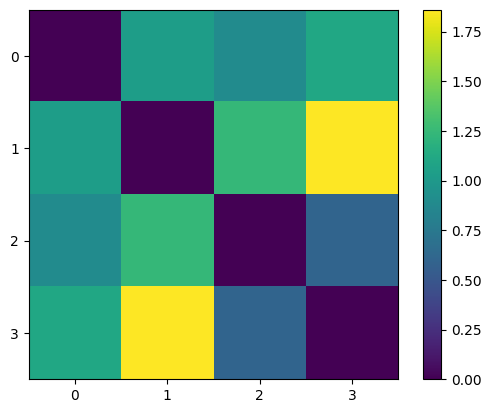

In [ ]:
out_couplings = hi[1]
norm_couplings = np.linalg.norm(out_couplings, ord='fro', axis=(2,3))
norm_couplings = norm_couplings + norm_couplings.T
print(norm_couplings)
plt.imshow(norm_couplings)
plt.colorbar()

ax = plt.gca()
xticks = [0,1,2,3]
yticks = xticks
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.show()

In [ ]:
import array_to_latex as a2l

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(data[0:10,:])
print(hi[0])
#a2l.to_ltx(data[0:10,:],arraytype='tabular')

[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 2 0 1]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 1 0]]
[[-0.687 0.354 0.333]
 [-0.784 0.226 0.558]
 [-0.685 0.288 0.397]
 [0.274 -0.331 0.056]]


In [107]:
import scipy.io
mat = scipy.io.loadmat('full_align_L4_q2.mat')
N = 1000
data_mh = mat['full_align'][0:N,:]
data_mh -= 1
L = 4
q = 2

print(data_mh[0:10,:])


# 1-2 coupled, fields zero, 3-4 coupled, both couplings strength = 0.8
fields = np.zeros((L,q))
couplings = np.zeros((L,L,q,q))
#print(fields)
x0 = tensor_array_to_vector([fields, couplings])

res_mh = minimize(objective, x0, args=(data_mh, L, q, N, ep), method='BFGS', options={"maxiter": 100})#, jac=gradient)

FileNotFoundError: [Errno 2] No such file or directory: 'full_align_L4_q2.mat'

In [ ]:
#print(x0)
print(data_mh[0:10,:])
hi = vector_to_tensor_array(res_mh.x,L,q)
print(res_mh)
#print(hi[1])
print(hi[0])
print(sum(hi[0][:,1])/4)

print(sum(data_mh[:,2] == 2))
#print(hi[1])
print(hi[1][0,1,:,:])
#print(hi[0], hi[1])

[[0 0 1 1]
 [1 1 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [1 0 0 0]
 [1 1 1 0]
 [0 0 0 0]]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.006693789970014068
        x: [-2.283e-03  2.284e-03 ...  0.000e+00  0.000e+00]
      nit: 10
      jac: [-9.546e-08  9.243e-08 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.309e+01 -1.209e+01 ...  0.000e+00  0.000e+00]
            [-1.209e+01  1.309e+01 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 1241
     njev: 17
[[-0.002 0.002]
 [0.010 -0.010]
 [-0.001 0.001]
 [-0.006 0.006]]
-4.1862755180209314e-06
0
[[-0.417 0.415]
 [0.427 -0.425]]


[[0.         1.03330223 0.89962609 1.11169608]
 [1.03330223 0.         1.23824606 1.86023622]
 [0.89962609 1.23824606 0.         0.60230585]
 [1.11169608 1.86023622 0.60230585 0.        ]]


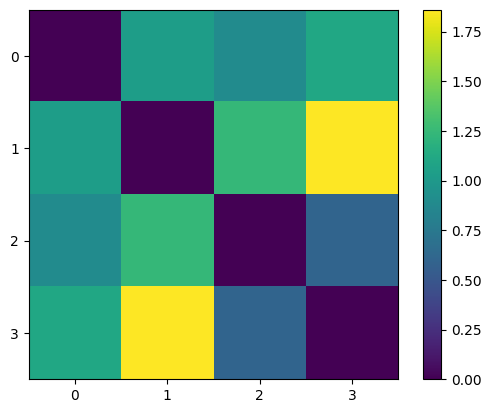

In [ ]:
out_couplings = hi[1]
norm_couplings = np.linalg.norm(out_couplings, ord='fro', axis=(2,3))
norm_couplings = norm_couplings + norm_couplings.T
print(norm_couplings)
plt.imshow(norm_couplings)
plt.colorbar()

ax = plt.gca()
xticks = [0,1,2,3]
yticks = xticks
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.show()

In [ ]:
mat_mhlarge = scipy.io.loadmat('full_align_L6_q3.mat')
print(mat_mhlarge)
N = 1000
data_mhlarge = mat_mhlarge['full_align'][0:N,]
data_mhlarge -= 1
L = 6
q = 3

print(data_mhlarge[0:10,:])


# 1-2 coupled, fields zero, 3-4 coupled, both couplings strength = 0.8
fields = np.zeros((L,q))
couplings = np.zeros((L,L,q,q))
#print(fields)
x0 = tensor_array_to_vector([fields, couplings])

res_mhlarge = minimize(objective, x0, args=(data_mhlarge, L, q, N, ep), method='BFGS', options={"maxiter": 100})#, jac=gradient)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue Mar  5 18:50:39 2024', '__version__': '1.0', '__globals__': [], 'full_align': array([[2, 2, 2, 1, 1, 2],
       [2, 2, 1, 1, 2, 3],
       [1, 1, 2, 2, 2, 2],
       ...,
       [3, 3, 3, 1, 1, 2],
       [3, 2, 1, 1, 1, 3],
       [2, 3, 1, 1, 1, 1]], dtype=uint8)}
[[1 1 1 0 0 1]
 [1 1 0 0 1 2]
 [0 0 1 1 1 1]
 [2 2 1 2 2 2]
 [1 1 0 0 2 0]
 [0 0 0 0 1 0]
 [0 2 2 1 1 2]
 [1 2 1 0 1 0]
 [0 1 0 1 1 0]
 [2 2 2 0 2 0]]


In [ ]:
#print(x0)
print(data_mhlarge[0:10,:])
hi = vector_to_tensor_array(res_mhlarge.x,L,q)
print(res_mhlarge)
#print(hi[1])
print(hi[0])
print(sum(hi[0][:,1])/4)

#print(sum(data_mhlarge[:,2] == 2))
#print(hi[1])
print(hi[1][0,1,:,:])
#print(hi[0], hi[1])

[[1 1 1 0 0 1]
 [1 1 0 0 1 2]
 [0 0 1 1 1 1]
 [2 2 1 2 2 2]
 [1 1 0 0 2 0]
 [0 0 0 0 1 0]
 [0 2 2 1 1 2]
 [1 2 1 0 1 0]
 [0 1 0 1 1 0]
 [2 2 2 0 2 0]]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.016477634397400718
        x: [-4.116e-03 -2.072e-02 ...  0.000e+00  0.000e+00]
      nit: 34
      jac: [ 4.420e-06  3.294e-06 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 2.782e+01  1.985e+01 ...  0.000e+00  0.000e+00]
            [ 1.985e+01  1.621e+01 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 13720
     njev: 40
[[-0.004 -0.021 0.025]
 [-0.010 0.003 0.008]
 [-0.023 0.010 0.012]
 [-0.017 0.012 0.005]
 [0.032 -0.025 -0.007]
 [0.012 0.018 -0.030]]
-0.0006025108109459524
[[-0.571 0.188 0.379]
 [0.312 -0.485 0.152]
 [0.248 0.299 -0.523]]


[[0.000 1.134 0.284 0.077 0.150 0.111]
 [1.134 0.000 0.255 0.138 0.253 0.124]
 [0.284 0.255 0.000 0.208 0.218 0.163]
 [0.077 0.138 0.208 0.000 1.116 0.187]
 [0.150 0.253 0.218 1.116 0.000 0.206]
 [0.111 0.124 0.163 0.187 0.206 0.000]]


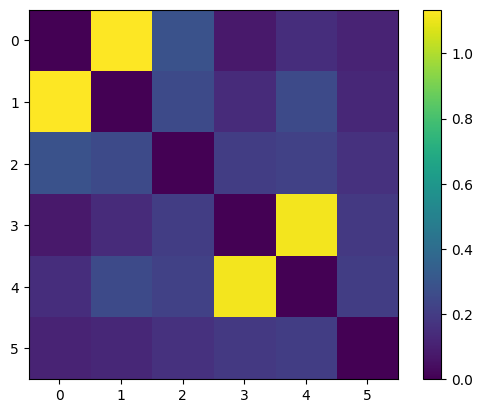

In [ ]:
out_couplings = hi[1]
norm_couplings = np.linalg.norm(out_couplings, ord='fro', axis=(2,3))
norm_couplings = norm_couplings + norm_couplings.T
print(norm_couplings)
plt.imshow(norm_couplings)
plt.colorbar()

ax = plt.gca()
xticks = [0,1,2,3,4,5]
yticks = xticks
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.show()